In [1]:
pip install -U -q seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

In [3]:
print("Torch MPS backend available: ", torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print("MPS backend is built: ", torch.backends.mps.is_built())
 
if torch.backends.mps.is_available():
    print ("using MPS device")
    device = torch.device("mps")
else:
    print ("MPS device not found")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Torch MPS backend available:  False
MPS backend is built:  False
MPS device not found


In [4]:
repositories = ["/kaggle/input/genai-hallucinations/mistral-queries/"]
json_map = dict()
for repo in repositories:
    files = [item for item in os.listdir(repo) if item.endswith(".json")]
    for file in files:
        json_map[file] = repo + file
        
print(f"available query json: {len(json_map)}")
mixture = [item.split(".")[0] for item in json_map.keys()]
mixture_names, mixture_counts = np.unique(mixture, return_counts=True)
for name, counts in zip(mixture_names, mixture_counts):
    print(f"{name:10} : {counts}")

available query json: 18671
cot        : 1465
flan       : 9347
niv        : 1686
t0         : 6173


In [5]:
def create_qq_plot(values, name="Distance"):
    standardized = (values - np.mean(values)) / np.std(values)
    fig, ax = plt.subplots(figsize=(6, 6))
    sm.qqplot(standardized, line='45', fit=True, marker='o', markerfacecolor='none', markeredgecolor='b', ax=ax)
    ax.set_title(f'QQ Plot of {name}')
    plt.show()

def make_positive(values):
    if np.min(values) <= 0:
        positive_values = values - np.min(values) + 1
    else:
        positive_values = values
    return positive_values
    
def plot_distribution(values, name="Distance", show_mean=True, show_median=True, show_legend=True):
    """Plots the distribution of the distance between the observed and expected data.

    Args:
        distance: A NumPy array containing the distance data.
        distance_name: The name of the distance metric.
        show_mean: Whether to plot the mean of the distance data on both panels.
        show_median: Whether to plot the median of the distance data on both panels.
        show_legend: Whether to show a legend on the KDE plot.
    """

    # Calculate the mean, median, and quantiles of the distance data.
    mean = np.mean(values)
    median = np.median(values)
    q1 = np.percentile(values, 25)
    q4 = np.percentile(values, 75)
    pct_01 = np.percentile(values, 1)
    pct_05 = np.percentile(values, 5)
    pct_10 = np.percentile(values, 10)
    pct_90 = np.percentile(values, 90)
    pct_95 = np.percentile(values, 95)
    pct_99 = np.percentile(values, 99)
        
    positive_values = make_positive(values)
    log_values = np.log(positive_values)

    # Create a figure with four subplots.
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

    # Plot the histogram of the distance data.
    axs[0, 0].hist(values, bins=50, color='darkblue', alpha=0.5)
    axs[0, 0].set_xlabel(name)
    axs[0, 0].set_ylabel("Count")
    axs[0, 0].set_title("Histogram")

    if show_mean:
        axs[0, 0].axvline(mean, color='red', linestyle='dashed')
    if show_median:
        axs[0, 0].axvline(median, color='green', linestyle='dashed')

    # Plot the KDE plot of the distance data.
    sns.kdeplot(values, color="blue", linewidth=2, ax=axs[0, 1])
    axs[0, 1].set_xlabel(name)
    axs[0, 1].set_ylabel("Probability Density")
    axs[0, 1].set_title("KDE Plot")

    if show_mean:
        axs[0, 1].axvline(mean, color='red', linestyle='dashed', label="mean")
    if show_median:
        axs[0, 1].axvline(median, color='green', linestyle='dashed', label="median")

    if show_legend and (show_mean or show_median):
        axs[0, 1].legend()

    # Plot the KDE plot of the log-transformed distance data.
    sns.kdeplot(log_values, color="blue", linewidth=2, ax=axs[1, 0])
    axs[1, 0].set_xlabel(name)
    axs[1, 0].set_ylabel("Probability Density of log transformed")
    axs[1, 0].set_title("KDE Log Plot")

    # loglog plot
    hist, bin_edges = np.histogram(values, bins=50)
    plt.loglog(bin_edges[:-1], hist)
    axs[1, 1].set_xlabel("log(bin edge value)")
    axs[1, 1].set_ylabel("log(frequency)")
    axs[1, 1].set_title("Log-log Plot")

    # Adjust the subplot spacing and show the plot.
    fig.tight_layout()

    # Print descriptive statistics of the distance data, rounded to 3 decimal figures.
    print(f"Descriptive statistics of {name}:")
    print(f"Minimum: {np.min(values):0.3f}")
    print(f"Percentile 01: {pct_01:0.3f}")
    print(f"Percentile 05:{pct_05:0.3f}")
    print(f"Percentile 10: {pct_10:0.3f}")
    print(f"Q1: {q1: 0.3f}")
    print(f"Mean: {mean:0.3f}")
    print(f"Standard deviation: {np.std(values):0.3f}")
    print(f"Median: {median:0.3f}")
    print(f"Q4: {q4:0.3f}")
    print(f"Percentile 90: {pct_90:0.3f}")
    print(f"Percentile 95: {pct_95:0.3f}")
    print(f"Percentile 99: {pct_99:0.3f}")
    print(f"Maximum: {np.max(values):0.3f}")

    plt.show()
    create_qq_plot(values, name)

In [6]:
def get_selfcheckGPT_1gram(json_item, eta=0.00001):
    R = json_item["output"]["results"][str(0)]["tokens"]
    corpus = list()
    for i in range(0, 21):
        corpus += json_item["output"]["results"][str(i)]["tokens"]
    keys, values = np.unique(corpus, return_counts=True)
    language_model = dict(zip(keys, values / len(corpus)))
    p = [language_model.get(item, eta) for item in R]
    if len(p) == 0:
        return None, None
    s_avg_ngram = np.mean(np.log(p) * -1)
    s_max_ngram = np.max(np.log(p) * -1)
    return s_avg_ngram, s_max_ngram

In [7]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

def get_embeddings_similarities(json_item, device=device):

    input_texts = ["".join(json_item["output"]["results"][str(i)]["tokens"]) for i in range(0, 21)]

    tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small") # "thenlper/gte-small" "thenlper/gte-base" "thenlper/gte-large"
    model = AutoModel.from_pretrained("thenlper/gte-small")
    model = model.to(device)

    # Tokenize the input texts
    batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
    batch_dict = batch_dict.to(device)
    outputs = model(**batch_dict)
    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask']) #.detach().numpy()

    # normalize embeddings for semantic similarity
    embeddings = F.normalize(embeddings, p=2, dim=1)
    scores = (embeddings[:1] @ embeddings[1:].T)
    if device != "cpu":
        scores = scores.cpu().detach().numpy()
    else:
        scores = scores.detach().numpy()

    worst_cosine_similarity = np.min(scores)
    average_cosine_similarity = np.mean(scores)
    
    return average_cosine_similarity, worst_cosine_similarity

In [8]:
def get_logloss(json_item):
    output = [json_item["output"]["results"][str(i)]["token_logprobs"] for i in range(0, 21) if json_item["output"]["results"][str(i)]["token_logprobs"]]
    avg_minus_log_p = np.mean([np.mean(np.array(item) * -1) for item in output])
    max_minus_log_p = [np.max(np.array(item) * -1) for item in output][0]
    return avg_minus_log_p, max_minus_log_p

In [9]:
data = dict()
for file in tqdm(json_map):  
    with open(json_map[file], "r") as r:
        json_item = json.load(r)

    identifier = json_item["id"]
    model = json_item["output"]["model"]

    if model == 'mistral-7b-instruct-v0.1.Q5_K_M.gguf':
        pass
    else:
        pass
        # continue

    if json_item["output"]["results"]["0"]["tokens"]:
        s_avg_ngram, s_max_ngram = get_selfcheckGPT_1gram(json_item)
        if s_avg_ngram is not None:
            average_cosine_similarity, worst_cosine_similarity = get_embeddings_similarities(json_item)
            avg_minus_log_p, max_minus_log_p = get_logloss(json_item)
            data[str(identifier)] = {"s_avg_ngram": float(s_avg_ngram), 
                                     "s_max_ngram" : float(s_max_ngram),
                                     "average_cosine_similarity": float(average_cosine_similarity),
                                     "worst_cosine_similarity": float(worst_cosine_similarity),
                                     "avg_minus_log_p": float(avg_minus_log_p),
                                     "max_minus_log_p": float(max_minus_log_p),
                                    }

  0%|          | 0/18671 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

100%|██████████| 18671/18671 [2:02:19<00:00,  2.54it/s]


In [10]:
data = pd.DataFrame.from_dict(data, orient="index")

Descriptive statistics of Average minus logloss across samples:
Minimum: 0.003
Percentile 01: 0.082
Percentile 05:0.213
Percentile 10: 0.298
Q1:  0.444
Mean: 0.608
Standard deviation: 0.264
Median: 0.586
Q4: 0.744
Percentile 90: 0.936
Percentile 95: 1.082
Percentile 99: 1.410
Maximum: 2.973


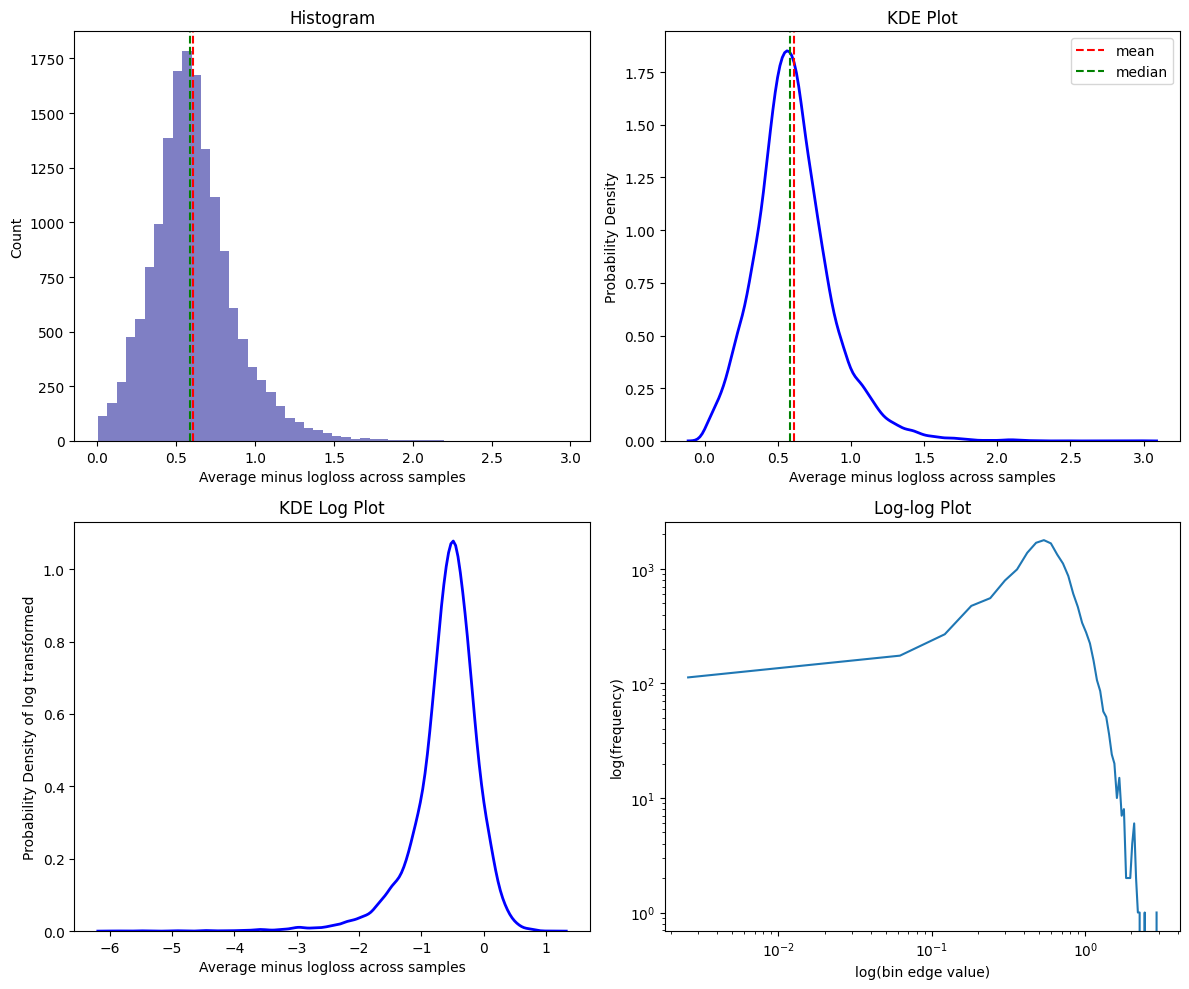

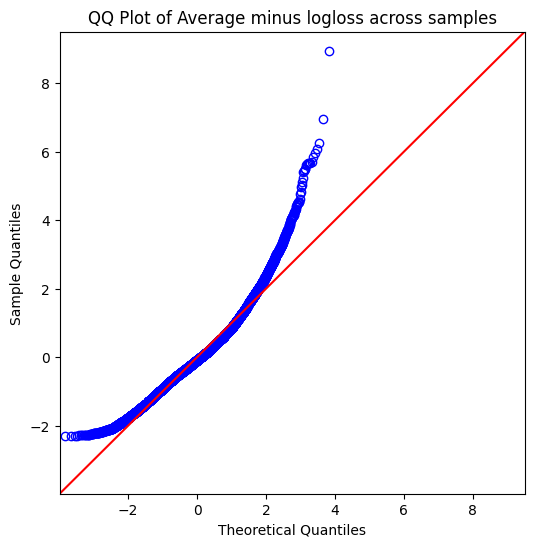

In [11]:
plot_distribution(data["avg_minus_log_p"], name="Average minus logloss across samples")

Descriptive statistics of Max minus token logloss for R:
Minimum: 0.009
Percentile 01: 0.108
Percentile 05:0.361
Percentile 10: 0.628
Q1:  1.259
Mean: 1.657
Standard deviation: 0.658
Median: 1.795
Q4: 2.098
Percentile 90: 2.368
Percentile 95: 2.573
Percentile 99: 2.967
Maximum: 4.043


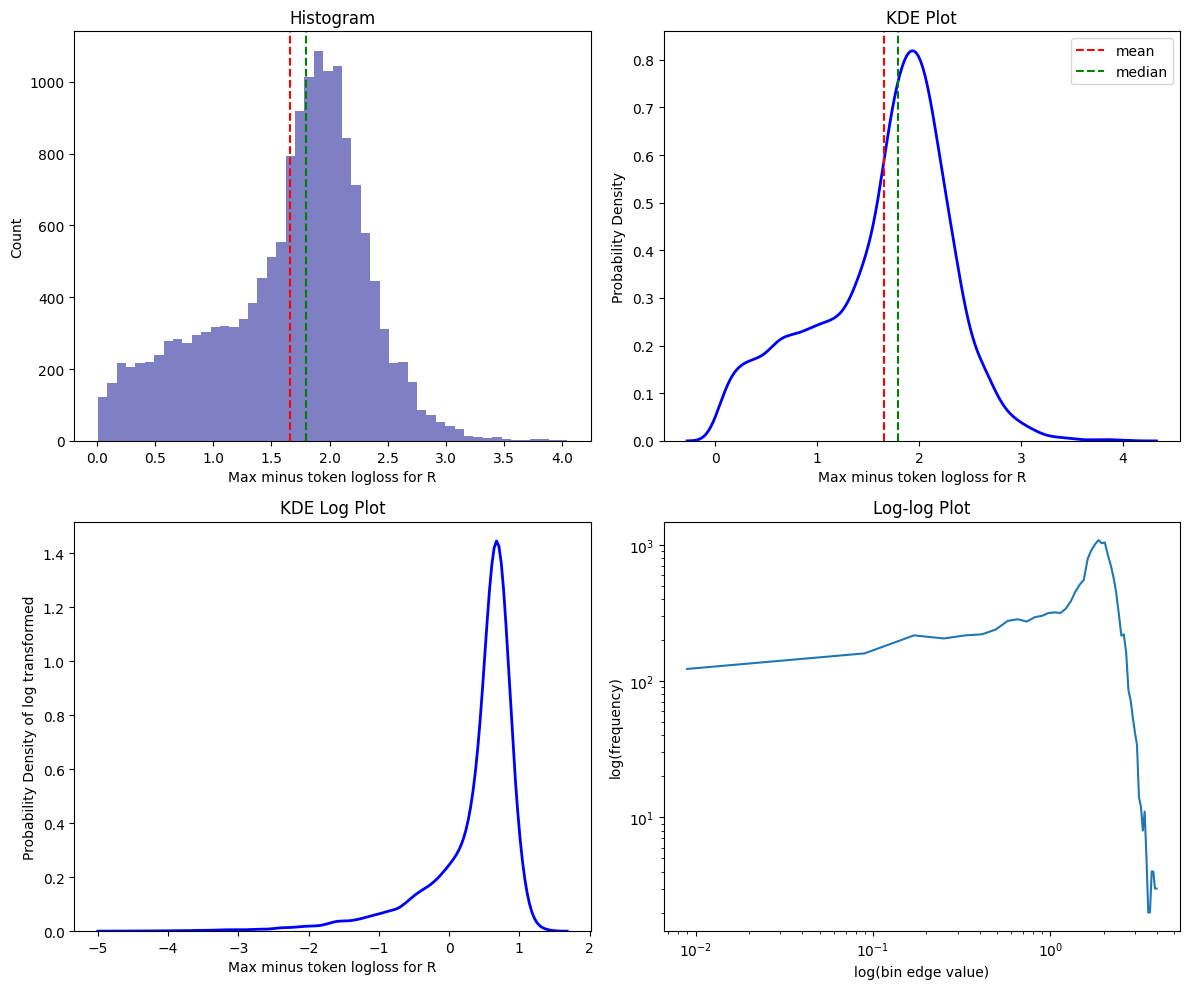

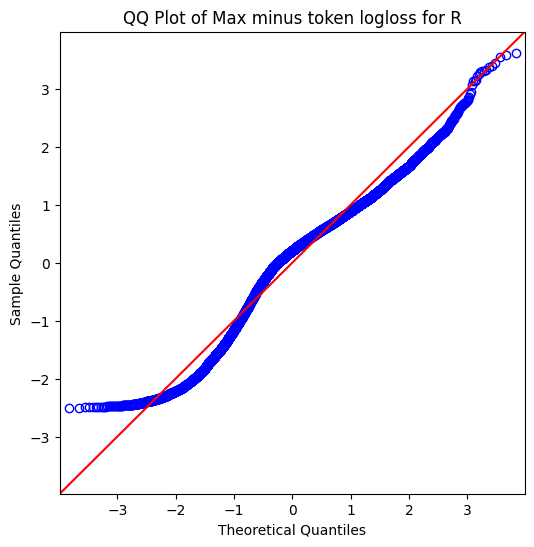

In [12]:
plot_distribution(data["max_minus_log_p"], name="Max minus token logloss for R")

Descriptive statistics of Average cosine similarity:
Minimum: 0.728
Percentile 01: 0.804
Percentile 05:0.842
Percentile 10: 0.861
Q1:  0.894
Mean: 0.922
Standard deviation: 0.044
Median: 0.928
Q4: 0.956
Percentile 90: 0.975
Percentile 95: 0.984
Percentile 99: 0.998
Maximum: 1.000


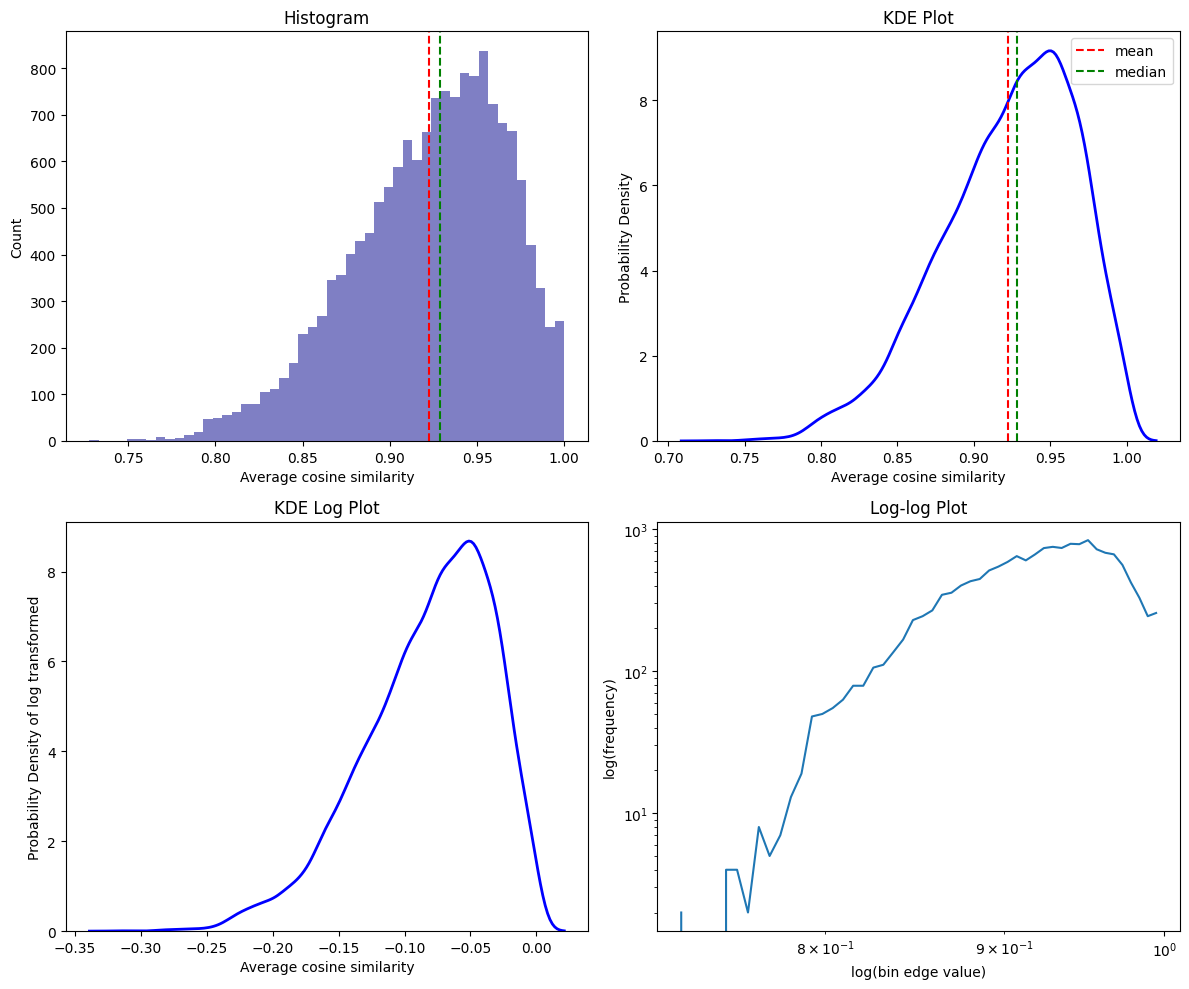

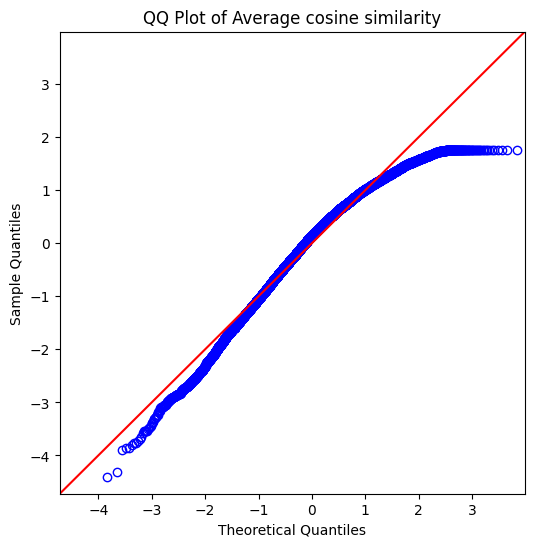

In [13]:
plot_distribution(data["average_cosine_similarity"], name="Average cosine similarity")

Descriptive statistics of Worst cosine similarity:
Minimum: 0.629
Percentile 01: 0.718
Percentile 05:0.742
Percentile 10: 0.757
Q1:  0.785
Mean: 0.833
Standard deviation: 0.064
Median: 0.822
Q4: 0.881
Percentile 90: 0.929
Percentile 95: 0.949
Percentile 99: 0.983
Maximum: 1.000


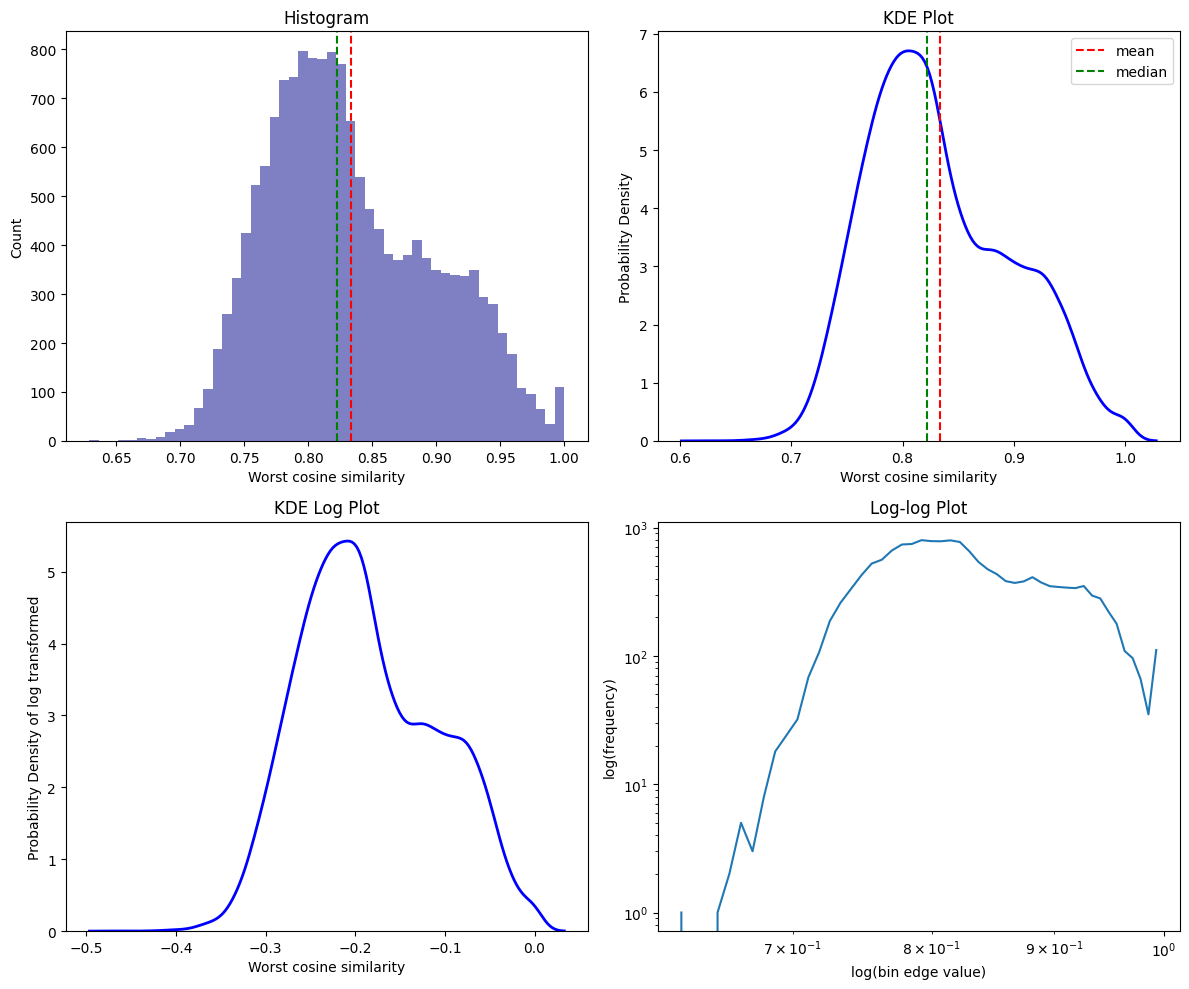

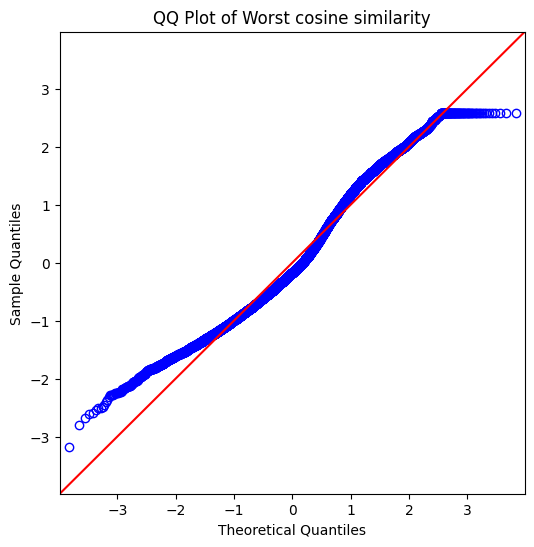

In [14]:
plot_distribution(data["worst_cosine_similarity"], name="Worst cosine similarity")

Descriptive statistics of SelfCheckGPT average 1-gram:
Minimum: 0.000
Percentile 01: 0.717
Percentile 05:1.782
Percentile 10: 2.432
Q1:  3.354
Mean: 3.972
Standard deviation: 1.095
Median: 4.201
Q4: 4.764
Percentile 90: 5.162
Percentile 95: 5.371
Percentile 99: 5.748
Maximum: 7.524


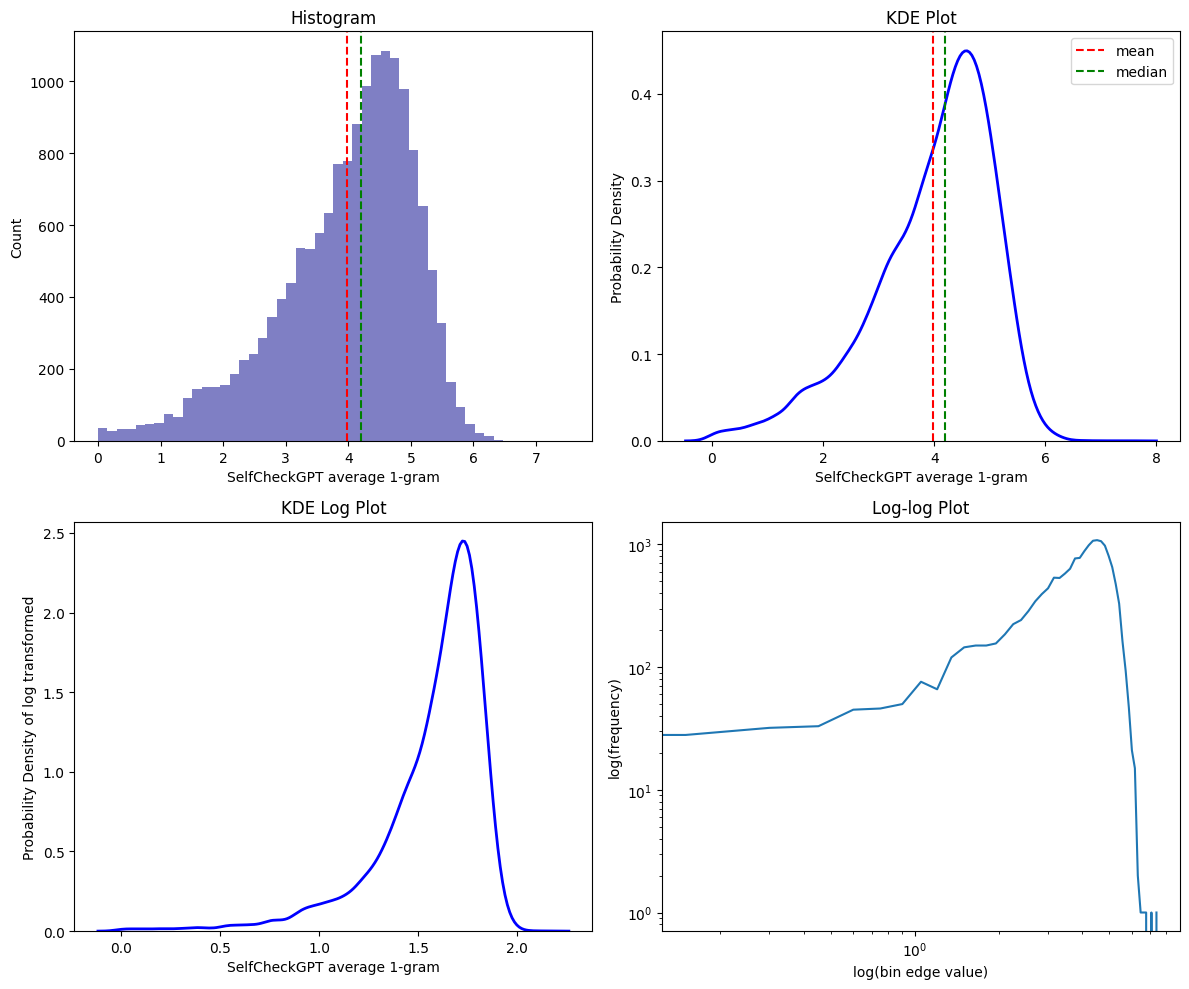

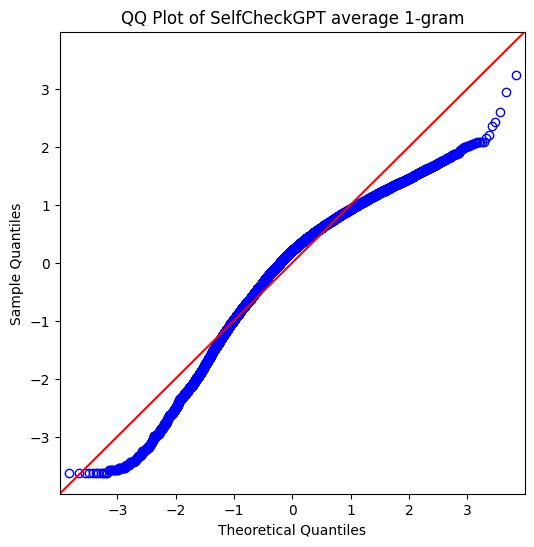

In [15]:
plot_distribution(data["s_avg_ngram"], name="SelfCheckGPT average 1-gram")

Descriptive statistics of SelfCheckGPT max 1-gram:
Minimum: -0.000
Percentile 01: 0.727
Percentile 05:1.908
Percentile 10: 2.661
Q1:  4.066
Mean: 5.702
Standard deviation: 2.129
Median: 6.009
Q4: 7.554
Percentile 90: 8.216
Percentile 95: 8.539
Percentile 99: 9.046
Maximum: 9.539


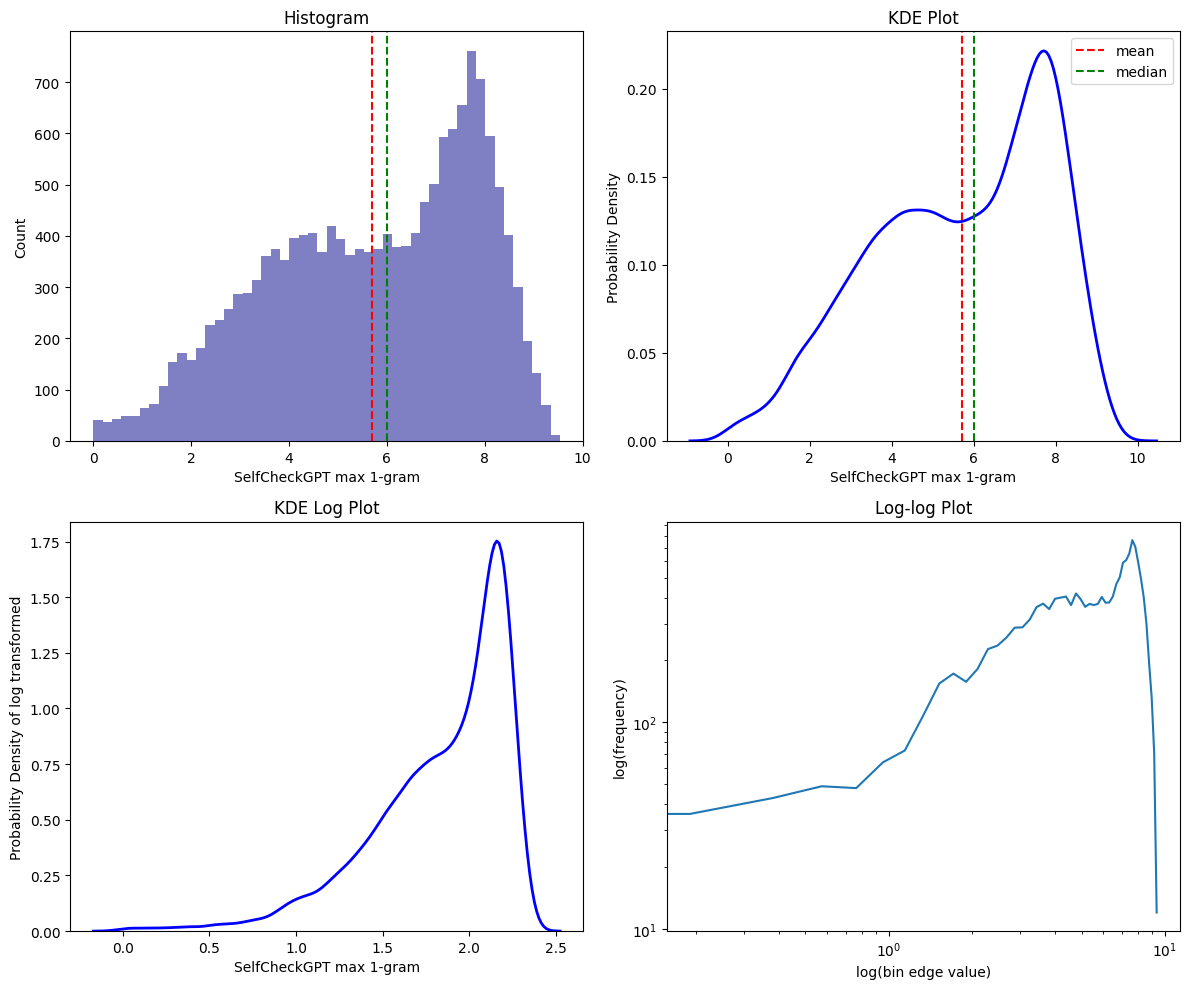

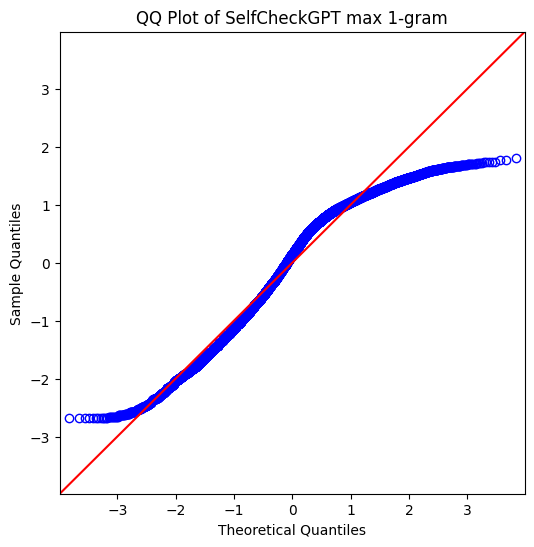

In [16]:
plot_distribution(data["s_max_ngram"], name="SelfCheckGPT max 1-gram")